<a href="https://colab.research.google.com/github/ormorteey/BST-222-Survival-Analysis/blob/main/BST_222_HW_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
install.packages("pacman")
library("pacman")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
p_load("tidyverse", "googledrive", "KMsurv", "survival", "survminer", "ggplot2")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


KMsurv installed

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘matrixStats’, ‘RcppArmadillo’, ‘numDeriv’, ‘SparseM’, ‘MatrixModels’, ‘conquer’, ‘sp’, ‘openxlsx’, ‘minqa’, ‘nloptr’, ‘RcppEigen’, ‘carData’, ‘abind’, ‘pbkrtest’, ‘quantreg’, ‘maptools’, ‘rio’, ‘lme4’, ‘bitops’, ‘corrplot’, ‘car’, ‘markdown’, ‘RCurl’, ‘png’, ‘jpeg’, ‘ggrepel’, ‘ggsci’, ‘cowplot’, ‘ggsignif’, ‘polynom’, ‘rstatix’, ‘exactRankTests’, ‘mvtnorm’, ‘zoo’, ‘km.ci’, ‘xtable’, ‘gridtext’, ‘ggpubr’, ‘gridExtra’, ‘maxstat’, ‘survMisc’, ‘ggtext’



survminer installed



In [3]:
drive_deauth()
drive_user()
public_file = drive_get(as_id("1CXILLG1-6nRpczvQNnAWEpNdxKc0ed-2"))
drive_download(public_file, overwrite = TRUE)

ℹ Not logged in as any specific Google user.

File downloaded:

• addicts.txt <id: 1CXILLG1-6nRpczvQNnAWEpNdxKc0ed-2>

Saved locally as:

• addicts.txt



In [4]:
vars <- c("id","clinic","status","time","prison","methadone")
addicts <- read.table("addicts.txt",header=F,col.names=vars)

In [6]:
addicts$clinic = factor(addicts$clinic, labels = c("1", " 2"))
addicts$prison = factor(addicts$prison, labels = c("No", "Yes"))
# addicts$status = factor(addicts$status, labels = c("0", "1"))
head(addicts)


,id,clinic,status,time,prison,methadone
,<int>,<fct>,<int>,<int>,<fct>,<int>
1,1,1,1,428,No,50
2,2,1,1,275,Yes,55
3,3,1,1,262,No,55
4,4,1,1,183,No,30
5,5,1,1,259,Yes,65
6,6,1,1,714,No,55


## **Q 1**

Test proportionality of hazards with cox.zph on the model with clinic, prison, and methadone. Make the three plots vs. time of the Schoenfeld residuals for clinic, prison, and methadone. Interpret the results

In [9]:
survival = Surv(time = addicts$time, event = addicts$status)
cox_model_1 <- coxph(survival~ clinic + prison + methadone, data = addicts)
print(summary(cox_model_1))

Call:
coxph(formula = survival ~ clinic + prison + methadone, data = addicts)

  n= 238, number of events= 150 

               coef exp(coef)  se(coef)      z Pr(>|z|)    
clinic 2  -1.009896  0.364257  0.214889 -4.700 2.61e-06 ***
prisonYes  0.326555  1.386184  0.167225  1.953   0.0508 .  
methadone -0.035369  0.965249  0.006379 -5.545 2.94e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

          exp(coef) exp(-coef) lower .95 upper .95
clinic 2     0.3643     2.7453    0.2391    0.5550
prisonYes    1.3862     0.7214    0.9988    1.9238
methadone    0.9652     1.0360    0.9533    0.9774

Concordance= 0.665  (se = 0.025 )
Likelihood ratio test= 64.56  on 3 df,   p=6e-14
Wald test            = 54.12  on 3 df,   p=1e-11
Score (logrank) test = 56.32  on 3 df,   p=4e-12



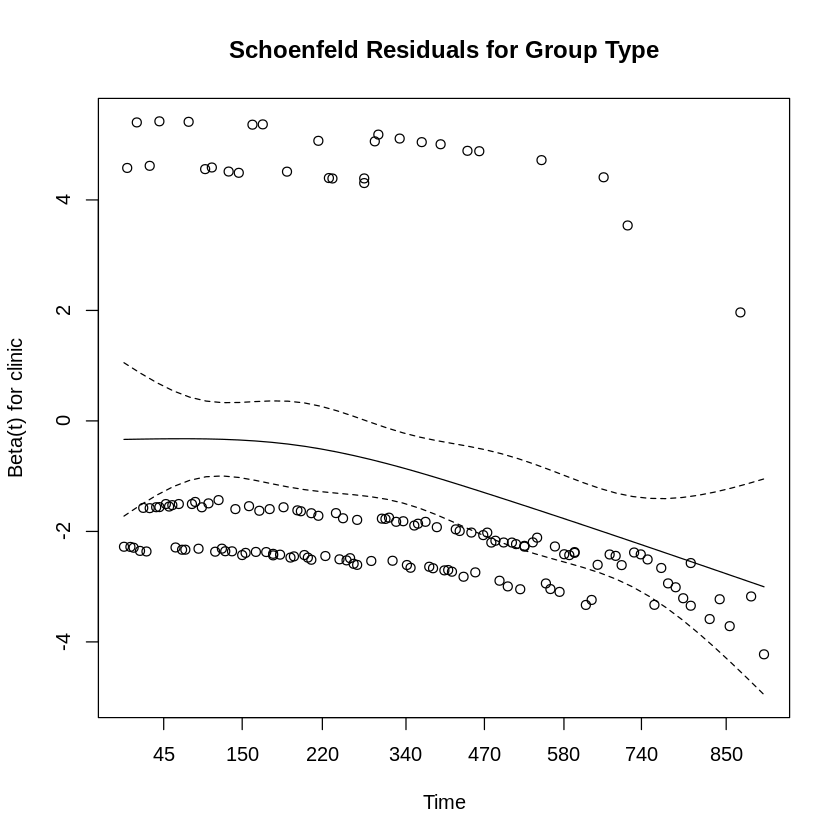

In [10]:
addicts.zph <- cox.zph(cox_model_1)
plot(addicts.zph[1], main = "Schoenfeld Residuals for Group Type")


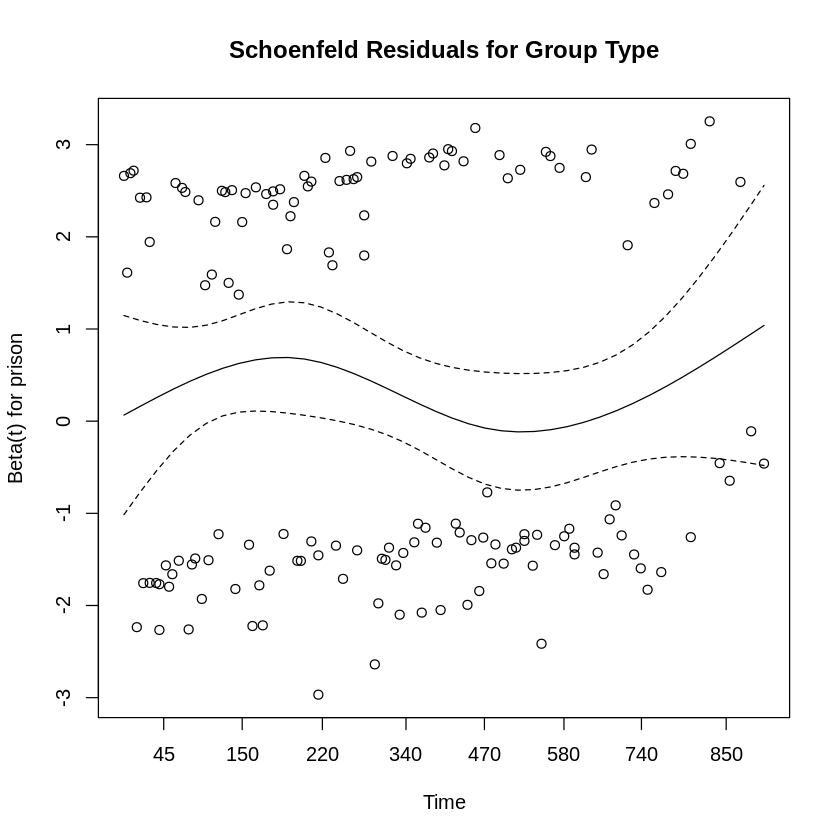

In [11]:
plot(addicts.zph[2], main = "Schoenfeld Residuals for Prison")

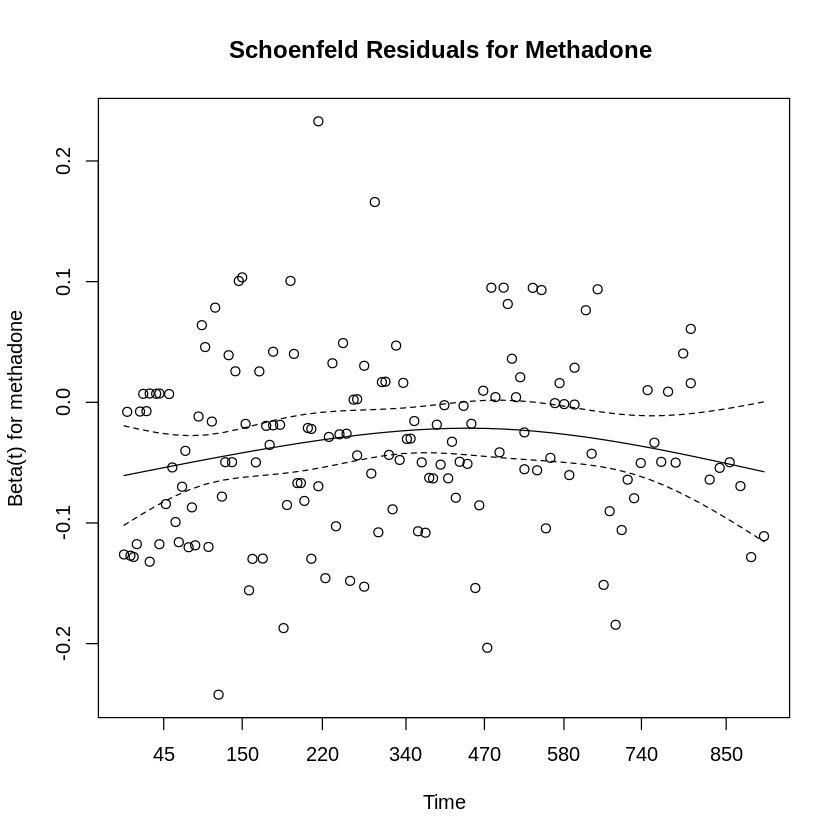

In [12]:
plot(addicts.zph[3], main = "Schoenfeld Residuals for Methadone ")

#### **Interpretation**

### **Q 2**

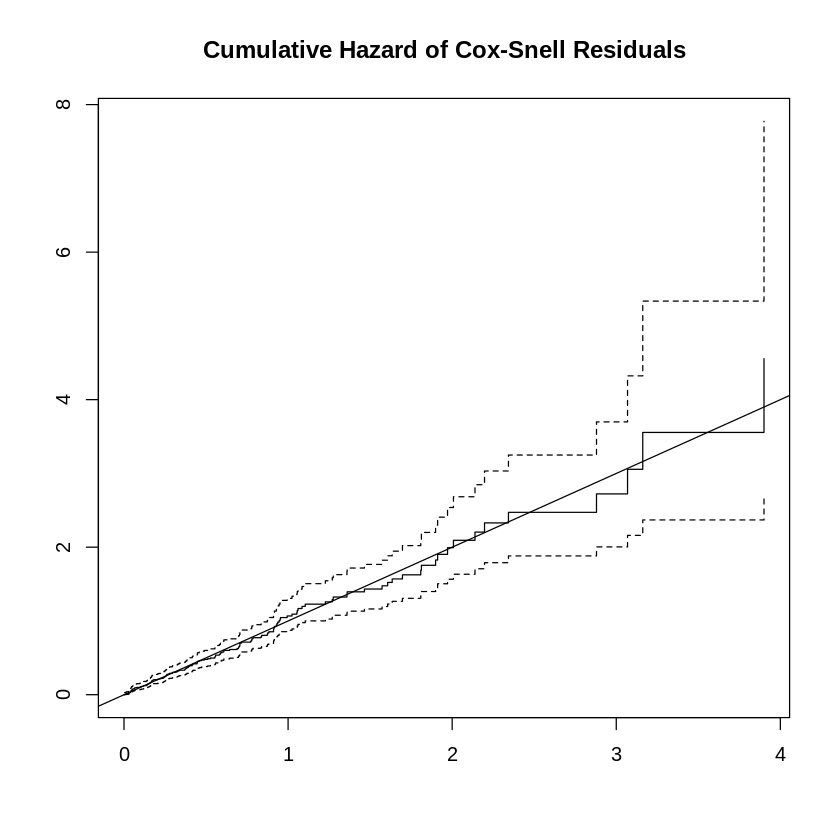

In [13]:
#fit martingale for full model
addicts.mart <- residuals(cox_model_1, type="martingale")
#find cox-snell residuals
addicts.cs <- addicts$status - addicts.mart
#cumaltive hazard of CS residuals
surv.csr <- survfit(Surv(addicts.cs,addicts$status)~1,type="fleming-harrington")

plot(surv.csr,fun="cumhaz")
abline(0,1)
title("Cumulative Hazard of Cox-Snell Residuals")

Plot the martingale residuals (omitting methadone) vs. methodone. The original paper using these data treated dose as a categorical variable with categories < 60, 60–79, and 80+. Make a categorized methadone variable using cut. Try fitting the model using categorized dose as a factor and compare to dose in statistical significance of the variable using the LR test (maybe with drop1) . Compare the two full models by AIC. Does it make an important difference to replace the quantitative variable by a 3-category factor? Note that you cannot compare the two models directly by a LR test since they are not nested.

Call:
coxph(formula = survival ~ clinic + prison, data = addicts)

  n= 238, number of events= 150 

             coef exp(coef) se(coef)      z Pr(>|z|)    
clinic 2  -1.1089    0.3299   0.2144 -5.173  2.3e-07 ***
prisonYes  0.2778    1.3203   0.1656  1.678   0.0933 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

          exp(coef) exp(-coef) lower .95 upper .95
clinic 2     0.3299     3.0309    0.2168    0.5022
prisonYes    1.3203     0.7574    0.9544    1.8263

Concordance= 0.599  (se = 0.025 )
Likelihood ratio test= 33.78  on 2 df,   p=5e-08
Wald test            = 28.17  on 2 df,   p=8e-07
Score (logrank) test = 30.51  on 2 df,   p=2e-07



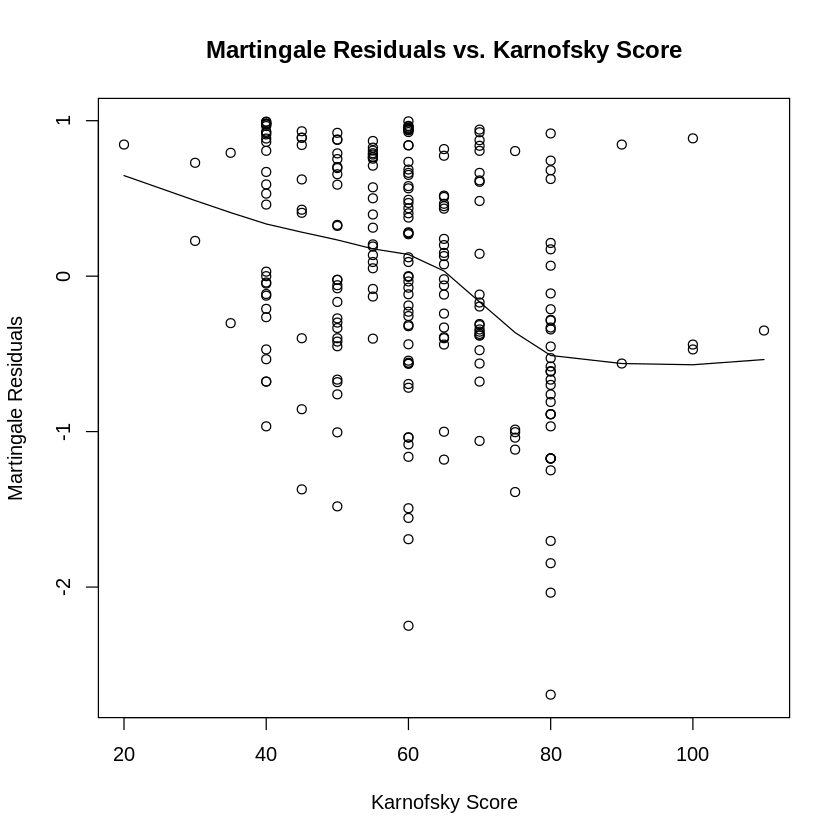

In [14]:
#fit without score
cox_model_2 <- coxph(survival~ clinic + prison, data = addicts)
print(summary(cox_model_2))
#find residuals
mres2 <- residuals(cox_model_2, type = "martingale")
#plot score vs residuals
plot(addicts$methadone,mres2,xlab="Karnofsky Score",ylab="Martingale Residuals")
lines(lowess(addicts$methadone,mres2))
title("Martingale Residuals vs. Karnofsky Score")

In [33]:
methadone_cat <- cut(addicts$methadone,c(0,60,80,max(addicts$methadone)+1),labels=c("Low","Medium", "High"))
table(methadone_cat)


methadone_cat
   Low Medium   High 
   145     87      6 

In [34]:

cox_model_3 <- coxph(survival~ clinic + prison + methadone_cat, data = addicts)
print(summary(cox_model_3))


Call:
coxph(formula = survival ~ clinic + prison + methadone_cat, data = addicts)

  n= 238, number of events= 150 

                       coef exp(coef) se(coef)      z Pr(>|z|)    
clinic 2            -0.9857    0.3732   0.2228 -4.424 9.71e-06 ***
prisonYes            0.2733    1.3143   0.1667  1.640    0.101    
methadone_catMedium -0.7354    0.4793   0.1810 -4.064 4.82e-05 ***
methadone_catHigh   -0.4418    0.6429   0.7425 -0.595    0.552    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                    exp(coef) exp(-coef) lower .95 upper .95
clinic 2               0.3732     2.6798    0.2411    0.5775
prisonYes              1.3143     0.7608    0.9480    1.8223
methadone_catMedium    0.4793     2.0863    0.3362    0.6834
methadone_catHigh      0.6429     1.5555    0.1500    2.7552

Concordance= 0.643  (se = 0.024 )
Likelihood ratio test= 51.51  on 4 df,   p=2e-10
Wald test            = 44.6  on 4 df,   p=5e-09
Score (logrank) test = 48.18  on 4 df,   p=

In [35]:
print(drop1(cox_model_1,test="Chisq"))

Single term deletions

Model:
survival ~ clinic + prison + methadone
          Df    AIC     LRT  Pr(>Chi)    
<none>       1352.5                      
clinic     1 1376.9 26.3506 2.847e-07 ***
prison     1 1354.3  3.7727   0.05209 .  
methadone  1 1381.3 30.7820 2.887e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [36]:
print(drop1(cox_model_3,test="Chisq"))

Single term deletions

Model:
survival ~ clinic + prison + methadone_cat
              Df    AIC     LRT Pr(>Chi)    
<none>           1367.6                     
clinic         1 1389.0 23.3799 1.33e-06 ***
prison         1 1368.2  2.6641 0.102638    
methadone_cat  2 1381.3 17.7331 0.000141 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


### **Q 4**

In [ ]:
#fit residuals
hodg.mart <- residuals(hodg.cox2,type="martingale")
hodg.dev <- residuals(hodg.cox2,type="deviance")
hodg.dfb <- residuals(hodg.cox2,type="dfbeta")
#find linear predictor
hodg.preds <- predict(hodg.cox2)